In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')

In [4]:
# Load and prepare the data
# Convert the CSV content to a DataFrame
df = pd.read_csv('train.csv')

# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn types:")
print(df.dtypes)

Dataset shape: (9800, 18)

First few rows:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Post

In [5]:
# Data preprocessing and time series preparation
# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

# Aggregate sales by date to create time series
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.set_index('Order Date')
daily_sales = daily_sales.asfreq('D')  # Set frequency to daily

print("Time series shape:", daily_sales.shape)
print("\nDate range:", daily_sales.index.min(), "to", daily_sales.index.max())
print("\nSample of daily sales:")
print(daily_sales.head(10))

Time series shape: (1458, 1)

Date range: 2015-01-03 00:00:00 to 2018-12-30 00:00:00

Sample of daily sales:
               Sales
Order Date          
2015-01-03    16.448
2015-01-04   288.060
2015-01-05    19.536
2015-01-06  4407.100
2015-01-07    87.158
2015-01-08       NaN
2015-01-09    40.544
2015-01-10    54.830
2015-01-11     9.940
2015-01-12       NaN


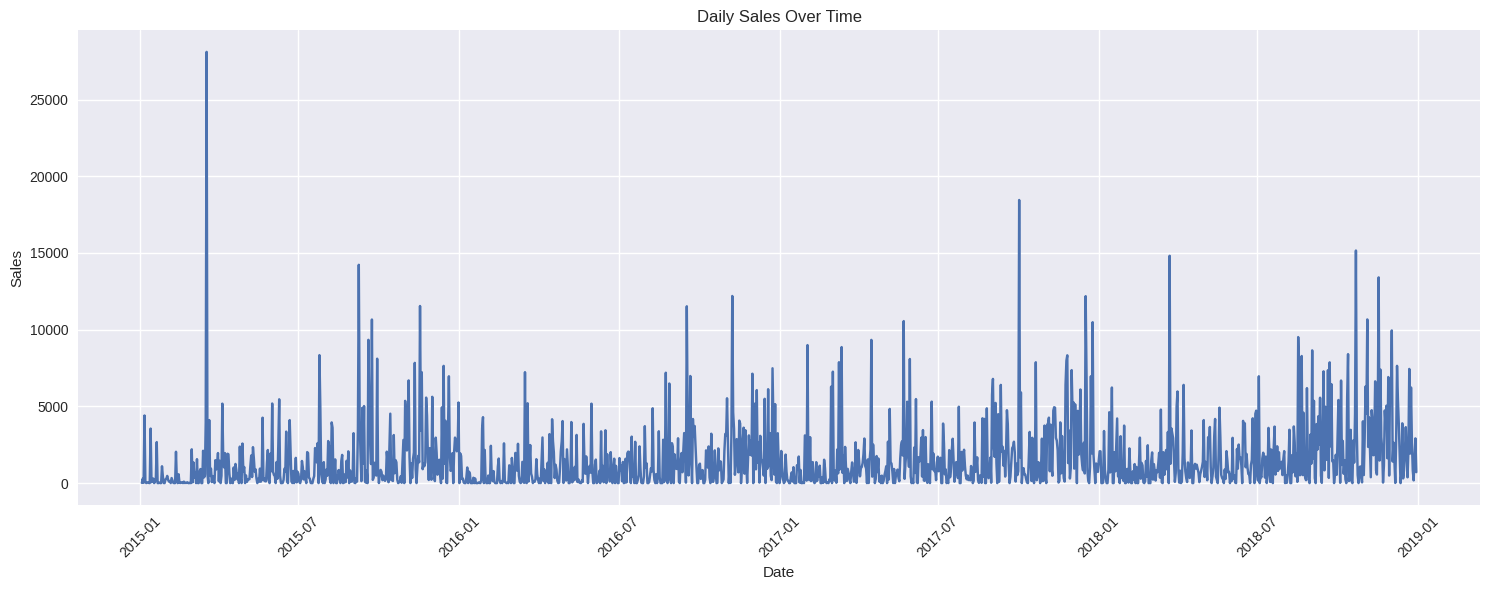


Stationarity check for original series:
ADF Statistic: -4.926583375196239
p-value: 3.094891245873596e-05
Critical Values:
	1%: -3.434908816804013
	5%: -2.863553406963303
	10%: -2.5678419239852994
Series is stationary


In [6]:
# Handle missing values and check for stationarity
# Fill missing dates with 0 sales (assuming no sales on those days)
daily_sales = daily_sales.fillna(0)

# Plot the original time series
plt.figure(figsize=(15, 6))
plt.plot(daily_sales.index, daily_sales['Sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

print("\nStationarity check for original series:")
check_stationarity(daily_sales['Sales'])

Stationarity check for differenced series:
ADF Statistic: -14.377499119666945
p-value: 9.271421499628596e-27
Critical Values:
	1%: -3.434908816804013
	5%: -2.863553406963303
	10%: -2.5678419239852994
Series is stationary


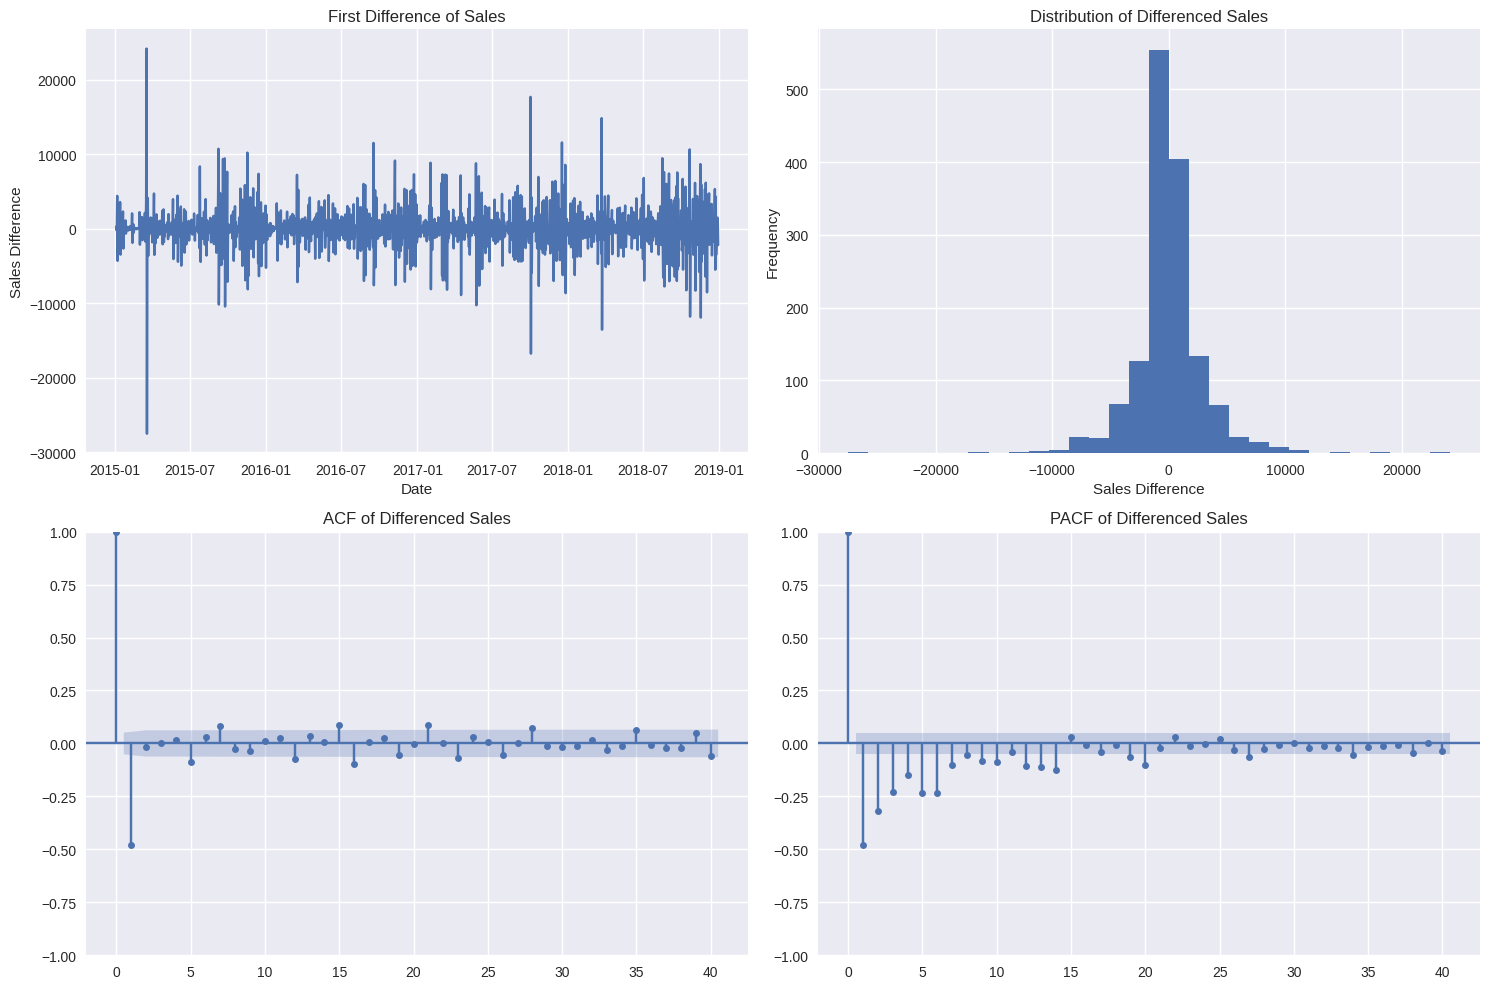

In [7]:
# Make data stationary through differencing
# First difference
sales_diff = daily_sales['Sales'].diff().dropna()

plt.figure(figsize=(15, 10))

# Plot differenced series
plt.subplot(2, 2, 1)
plt.plot(sales_diff.index, sales_diff)
plt.title('First Difference of Sales')
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.grid(True)

# Check stationarity of differenced series
plt.subplot(2, 2, 2)
plt.hist(sales_diff.dropna(), bins=30)
plt.title('Distribution of Differenced Sales')
plt.xlabel('Sales Difference')
plt.ylabel('Frequency')

print("Stationarity check for differenced series:")
check_stationarity(sales_diff)

# ACF and PACF plots for model identification
plt.subplot(2, 2, 3)
plot_acf(sales_diff.dropna(), ax=plt.gca(), lags=40)
plt.title('ACF of Differenced Sales')

plt.subplot(2, 2, 4)
plot_pacf(sales_diff.dropna(), ax=plt.gca(), lags=40)
plt.title('PACF of Differenced Sales')

plt.tight_layout()
plt.show()

In [8]:
# Split data into train and test sets
# Use last 30 days as test set
train_size = len(daily_sales) - 30
train_data = daily_sales.iloc[:train_size]
test_data = daily_sales.iloc[train_size:]

print(f"Training data: {len(train_data)} days")
print(f"Test data: {len(test_data)} days")
print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")

Training data: 1428 days
Test data: 30 days
Training period: 2015-01-03 00:00:00 to 2018-11-30 00:00:00
Test period: 2018-12-01 00:00:00 to 2018-12-30 00:00:00


In [9]:
# SARIMA model training
# Based on ACF/PACF analysis, let's use SARIMA(1,1,1)(1,1,1,7) model
# This captures weekly seasonality (7 days)

try:
    # Fit SARIMA model
    model = SARIMAX(train_data['Sales'],
                  order=(1, 1, 1),           # (p,d,q) - non-seasonal parameters
                  seasonal_order=(1, 1, 1, 7), # (P,D,Q,s) - seasonal parameters (weekly)
                  enforce_stationarity=False,
                  enforce_invertibility=False)

    model_fit = model.fit(disp=False)
    print("SARIMA model fitted successfully!")
    print(model_fit.summary())

except Exception as e:
    print(f"Error fitting model: {e}")
    # Try a simpler model if the complex one fails
    model = SARIMAX(train_data['Sales'],
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 7),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    print("Simpler SARIMA model fitted successfully!")
    print(model_fit.summary())

SARIMA model fitted successfully!
                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                 1428
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -12791.207
Date:                           Thu, 02 Oct 2025   AIC                          25592.414
Time:                                   15:20:35   BIC                          25618.675
Sample:                               01-03-2015   HQIC                         25602.227
                                    - 11-30-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0213      0.028      0.775      0.438      -0.033       0.075
ma.L1    

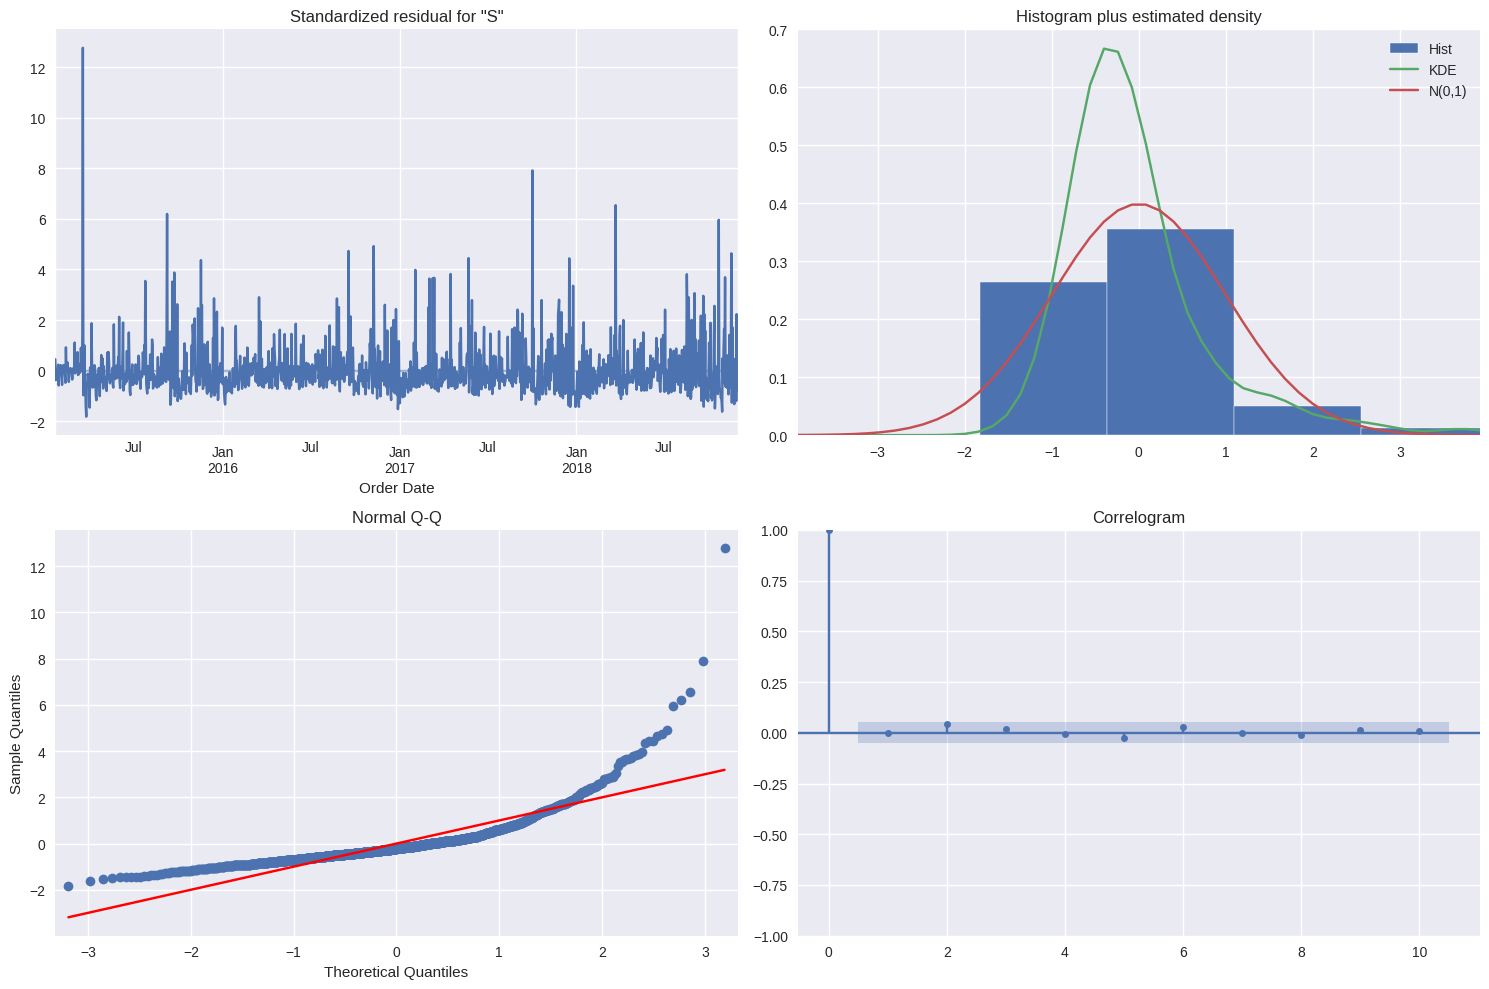


Residuals Description:
count     1428.000000
mean         8.900851
std       2087.727723
min      -3891.014212
25%      -1131.402316
50%       -434.217447
75%        452.075713
max      27323.120536
dtype: float64

Ljung-Box test p-value: 0.7955


In [10]:
#Model diagnostics
# Plot model diagnostics
model_fit.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.show()

# Check residuals
residuals = model_fit.resid
print("\nResiduals Description:")
print(residuals.describe())

# Ljung-Box test for autocorrelation in residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals.dropna(), lags=10)
print(f"\nLjung-Box test p-value: {lb_test['lb_pvalue'].iloc[-1]:.4f}")

In [11]:
#Make predictions on test set
# Forecast for the test period (30 days)
forecast_test = model_fit.get_forecast(steps=len(test_data))
forecast_test_values = forecast_test.predicted_mean
forecast_test_conf_int = forecast_test.conf_int()

# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_data['Sales'], forecast_test_values)
rmse = np.sqrt(mean_squared_error(test_data['Sales'], forecast_test_values))
mape = np.mean(np.abs((test_data['Sales'] - forecast_test_values) / test_data['Sales'])) * 100

print(f"Model Performance on Test Set:")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

Model Performance on Test Set:
MAE: $2122.82
RMSE: $2413.95
MAPE: inf%


In [12]:
#Forecast future sales (next 30 days)
# Forecast beyond the test set
future_steps = 30
forecast_future = model_fit.get_forecast(steps=len(test_data) + future_steps)
forecast_future_values = forecast_future.predicted_mean
forecast_future_conf_int = forecast_future.conf_int()

# Create future dates
last_date = daily_sales.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

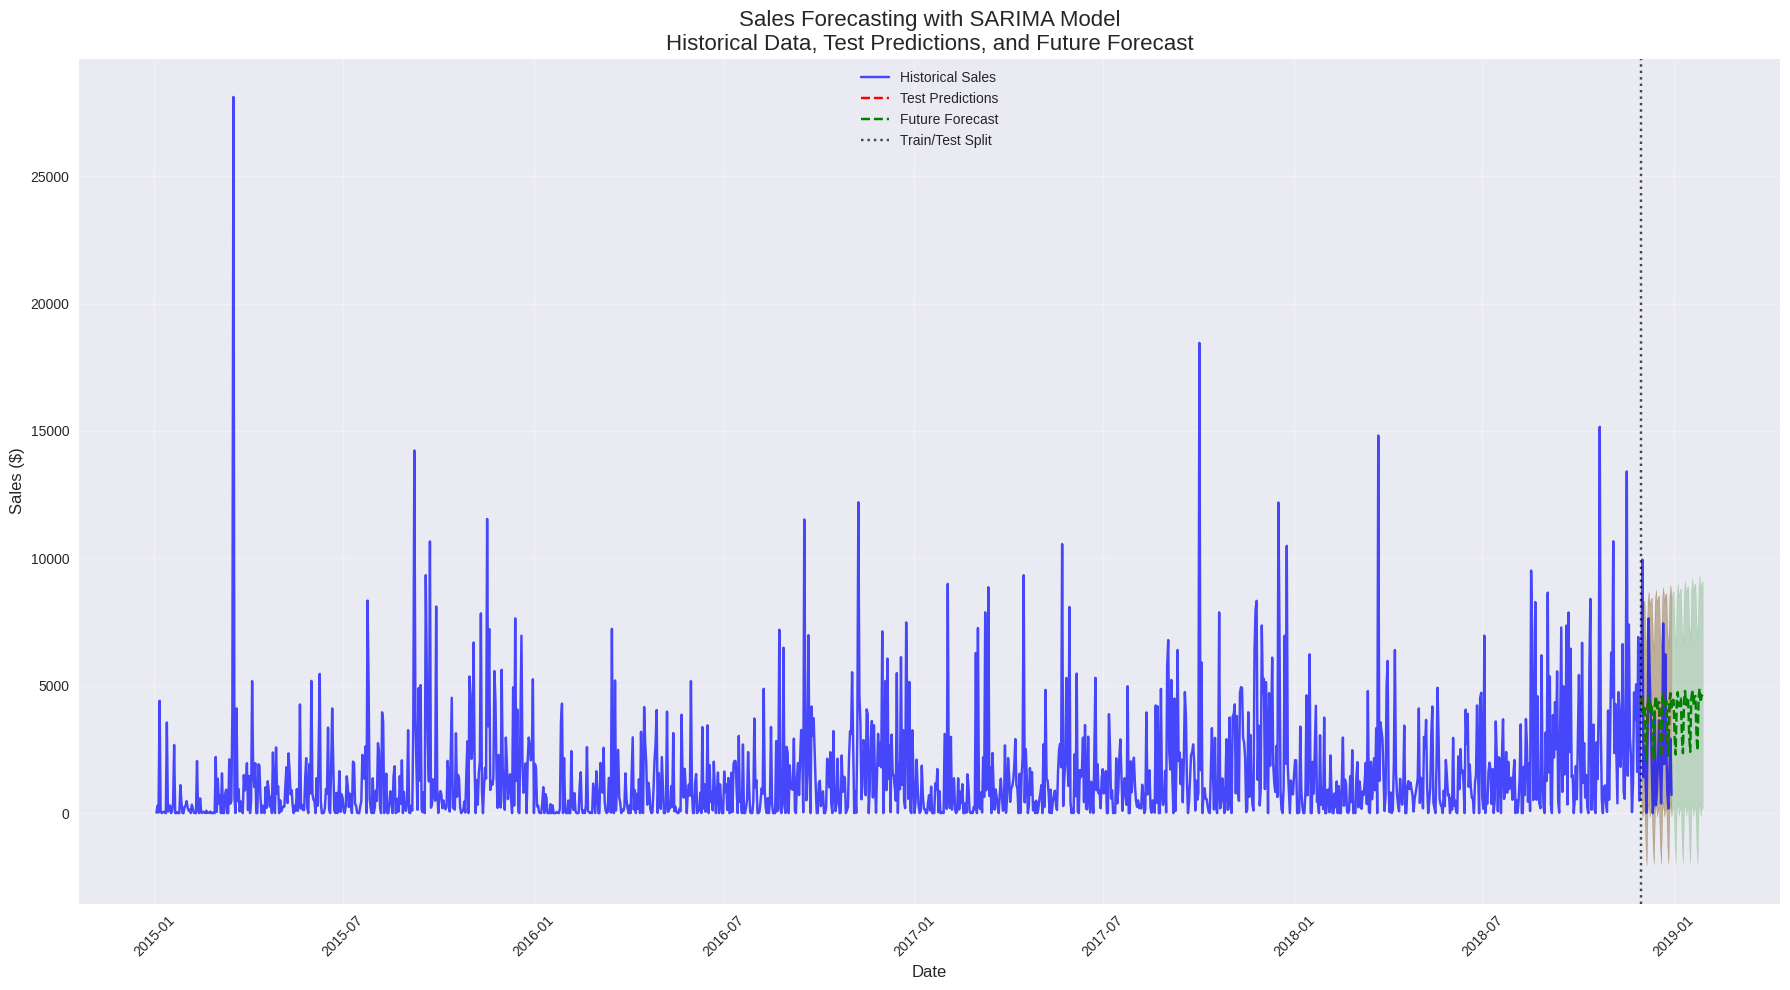

In [13]:
#Comprehensive visualization
plt.figure(figsize=(18, 10))

# Plot historical data
plt.plot(daily_sales.index, daily_sales['Sales'], label='Historical Sales', color='blue', alpha=0.7)

# Plot test period predictions
test_dates = test_data.index
plt.plot(test_dates, forecast_test_values, label='Test Predictions', color='red', linestyle='--')
plt.fill_between(test_dates,
                forecast_test_conf_int.iloc[:, 0],
                forecast_test_conf_int.iloc[:, 1],
                color='red', alpha=0.2)

# Plot future forecast
all_future_dates = list(test_dates) + list(future_dates)
all_future_forecast = list(forecast_test_values) + list(forecast_future_values[-future_steps:])
all_future_conf_lower = list(forecast_test_conf_int.iloc[:, 0]) + list(forecast_future_conf_int.iloc[-future_steps:, 0])
all_future_conf_upper = list(forecast_test_conf_int.iloc[:, 1]) + list(forecast_future_conf_int.iloc[-future_steps:, 1])

plt.plot(all_future_dates, all_future_forecast, label='Future Forecast', color='green', linestyle='--')
plt.fill_between(all_future_dates,
                all_future_conf_lower,
                all_future_conf_upper,
                color='green', alpha=0.2)

# Add vertical line separating historical and future
plt.axvline(x=test_data.index[0], color='black', linestyle=':', alpha=0.7, label='Train/Test Split')

plt.title('Sales Forecasting with SARIMA Model\nHistorical Data, Test Predictions, and Future Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
#Display forecast results in a table
# Create a DataFrame with future forecasts
future_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Sales': forecast_future_values[-future_steps:],
    'Lower_CI': forecast_future_conf_int.iloc[-future_steps:, 0],
    'Upper_CI': forecast_future_conf_int.iloc[-future_steps:, 1]
})

print("Future 30-Day Sales Forecast:")
print("=" * 70)
print(future_forecast_df.round(2))

# Summary statistics
print(f"\nForecast Summary (Next 30 Days):")
print(f"Average Daily Sales Forecast: ${future_forecast_df['Forecasted_Sales'].mean():.2f}")
print(f"Total Sales Forecast (30 days): ${future_forecast_df['Forecasted_Sales'].sum():.2f}")
print(f"Minimum Daily Forecast: ${future_forecast_df['Forecasted_Sales'].min():.2f}")
print(f"Maximum Daily Forecast: ${future_forecast_df['Forecasted_Sales'].max():.2f}")

Future 30-Day Sales Forecast:
                 Date  Forecasted_Sales  Lower_CI  Upper_CI
2018-12-31 2018-12-31           4410.22    141.21   8679.22
2019-01-01 2019-01-01           4448.40    174.47   8722.34
2019-01-02 2019-01-02           2960.25  -1318.61   7239.12
2019-01-03 2019-01-03           2303.07  -1980.72   6586.85
2019-01-04 2019-01-04           4328.71     40.01   8617.41
2019-01-05 2019-01-05           4745.40    443.25   9047.55
2019-01-06 2019-01-06           4195.17   -112.29   8502.63
2019-01-07 2019-01-07           4459.72    147.09   8772.36
2019-01-08 2019-01-08           4497.91    180.11   8815.71
2019-01-09 2019-01-09           3009.76  -1313.20   7332.72
2019-01-10 2019-01-10           2352.57  -1975.54   6680.69
2019-01-11 2019-01-11           4378.22     44.96   8711.48
2019-01-12 2019-01-12           4794.90    447.87   9141.94
2019-01-13 2019-01-13           4244.67   -107.91   8597.26
2019-01-14 2019-01-14           4509.23    151.24   8867.22
2019-01-15

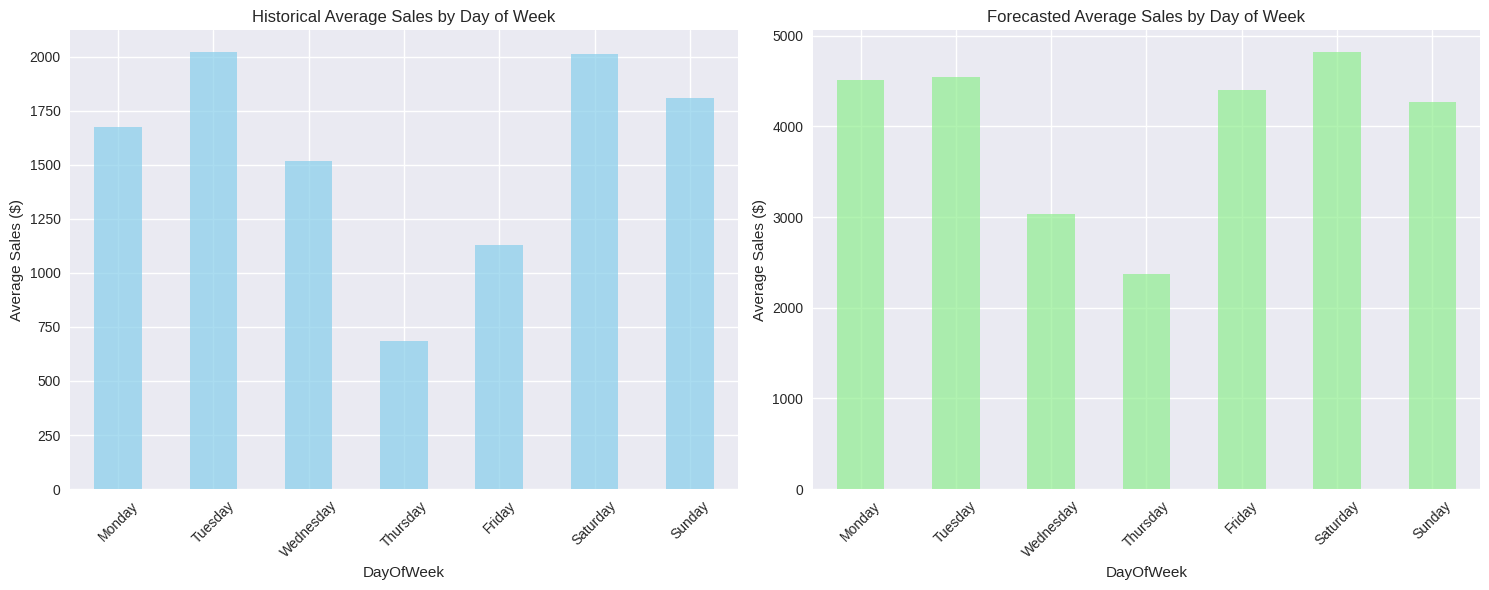

In [15]:
#Additional visualization - Weekly pattern analysis
# Extract day of week from dates
daily_sales['DayOfWeek'] = daily_sales.index.day_name()
future_forecast_df['DayOfWeek'] = future_forecast_df['Date'].dt.day_name()

# Calculate average sales by day of week (historical)
weekly_pattern = daily_sales.groupby('DayOfWeek')['Sales'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Forecast weekly pattern
future_weekly = future_forecast_df.groupby('DayOfWeek')['Forecasted_Sales'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Historical weekly pattern
weekly_pattern.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
ax1.set_title('Historical Average Sales by Day of Week')
ax1.set_ylabel('Average Sales ($)')
ax1.tick_params(axis='x', rotation=45)

# Forecast weekly pattern
future_weekly.plot(kind='bar', ax=ax2, color='lightgreen', alpha=0.7)
ax2.set_title('Forecasted Average Sales by Day of Week')
ax2.set_ylabel('Average Sales ($)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [16]:
# Save forecast to CSV
future_forecast_df.to_csv('sales_forecast_next_30_days.csv', index=False)
print("Forecast saved to 'sales_forecast_next_30_days.csv'")

# Save model summary to text file
with open('sarima_model_summary.txt', 'w') as f:
    f.write(str(model_fit.summary()))

print("Model summary saved to 'sarima_model_summary.txt'")

# Display final model parameters
print("\nFinal Model Parameters:")
print(f"SARIMA{model_fit.model.order}{model_fit.model.seasonal_order}")
print(f"AIC: {model_fit.aic:.2f}")
print(f"BIC: {model_fit.bic:.2f}")

Forecast saved to 'sales_forecast_next_30_days.csv'
Model summary saved to 'sarima_model_summary.txt'

Final Model Parameters:
SARIMA(1, 1, 1)(1, 1, 1, 7)
AIC: 25592.41
BIC: 25618.67
